In [1]:
import openai
import numpy as np
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

client = openai.OpenAI(api_key="sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP")
MODEL = "gpt-4o"

##################################################
def get_full_response(prompt, n=1, max_tokens=1000, temperature=0.7, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    for _ in range(n):
        response = client.chat.completions.create(
            model="gpt-4o",  # Replace with your model ID as needed
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
            logprobs=True,  # Enable logprobs
            top_logprobs=10  # Specify number of top log probabilities to return
        )

        # Print the entire response object
        return response
        
##################################################
def extract_chat_completion_data(response):
    # Data structure to hold the results
    data = {
        "Response Content": "",
        "Logprobs": [],
        "Top Logprob Words": [],
        "Top Logprob Values": []
    }
    
    # Assume the first choice for simplification; adapt as needed for multiple choices
    if response.choices:
        choice = response.choices[0]
        data["Response Content"] = choice.message.content
        
        # Extract token logprob information
        for token_logprob in choice.logprobs.content:
            # Append the logprob of the current token to the list
            data["Logprobs"].append(token_logprob.logprob)
            
            # For collecting top logprob words and their values
            top_words = []
            top_values = []
            
            # Extract top logprob details
            for top_logprob in token_logprob.top_logprobs:
                top_words.append(top_logprob.token)
                top_values.append(top_logprob.logprob)
            
            # Append each token's top logprob words and values
            data["Top Logprob Words"].append(top_words)
            data["Top Logprob Values"].append(top_values)

    return data

##################################################
def parse_conversations(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    conversations = content.split('\n\n')
    user_messages = []
    chatgpt_messages = []

    current_label = None
    current_message = []

    for conversation in conversations:
        lines = conversation.strip().split('\n')
        if len(lines) >= 1:
            if lines[0] == '#USER':
                if current_label == '##ChatGPT':
                    chatgpt_messages.append(' '.join(current_message))
                current_label = '#USER'
                current_message = lines[1:]
            elif lines[0] == '##ChatGPT':
                if current_label == '#USER':
                    user_messages.append(' '.join(current_message))
                current_label = '##ChatGPT'
                current_message = lines[1:]
            else:
                current_message.extend(lines)

    if current_label == '#USER':
        user_messages.append(' '.join(current_message))
    elif current_label == '##ChatGPT':
        chatgpt_messages.append(' '.join(current_message))

    return user_messages, chatgpt_messages

##################################################
def visualize_2d_grid(encoded_2d_grid, grid_size):
    # Applying Gaussian filter to smooth the grids
    smoothed_grids = np.array([gaussian_filter(grid, sigma=2) for grid in encoded_2d_grid])

    # Setting up the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Creating a meshgrid for the x and y coordinates
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    
    # Plotting each grid with an increasing offset in Z
    offset = 0.0
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i] + i * offset  # Offset each grid
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Setting labels and title
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')

    # Display the plot
    plt.show()
    
##################################################
def pad_token_probs(probabilities, pad_value=0):
    # Find the maximum length of the token probabilities list
    max_length = max(len(probs) for probs in probabilities)
    # Pad each probabilities list to the maximum length
    padded_probabilities = np.array([np.pad(probs, (0, max_length - len(probs)), 'constant', constant_values=pad_value) for probs in probabilities])
    return padded_probabilities

##################################################
def multi_layer_pool(hidden_states: list, attention_mask: Tensor, num_layers: int = 1) -> Tensor:
    """
    Extract embeddings from the last 'num_layers' layers and concatenate them.
    """
    # Get the last num_layers layers
    all_layers = hidden_states[-num_layers:]  
    # Concatenate them on the embedding dimension
    concatenated_layers = torch.cat(all_layers, dim=-1)  

    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return concatenated_layers[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = concatenated_layers.shape[0]
        return concatenated_layers[torch.arange(batch_size, device=concatenated_layers.device), sequence_lengths]

##################################################
def single_layer_pool(hidden_states, layer_index):
    """
    Extract embeddings from a specific layer.
    """
    selected_layer = hidden_states[layer_index]
    return selected_layer.mean(dim=1)  # Average over the token dimension to get a single vector per sequence

##################################################
def embed_text(input_texts, max_length=700, layer_index=-1, scaling_factor=1.0):
    try:
        # Tokenize the input texts with truncation and without padding
        batch_dict = tokenizer(input_texts, max_length=max_length, padding=False, truncation=True, return_tensors='pt').to(device)
        
        # Check the length of the tokenized input and ignore if it's less than 100
        token_length = batch_dict['input_ids'].shape[1]
        if token_length < 100:
            return None
        
        # Set output_hidden_states to True
        outputs = model(**batch_dict, output_hidden_states=True)
        
        # Use the new pooling method with specified layer
        embeddings = single_layer_pool(outputs.hidden_states, layer_index)
        
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Scale embeddings
        embeddings = embeddings * scaling_factor
        
        # Convert the embeddings to lists
        embedding_lists = embeddings.cpu().tolist()
        
        return embedding_lists
    
    except Exception as e:
        print(f"An error occurred: {e}")
    
    finally:
        try:
            del batch_dict
            del outputs
            del embeddings
            torch.cuda.empty_cache()
        except:
            pass

##################################################
def train_autoencoder(input_data, latent_dim=2500, num_epochs=50):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    
    # Encoder configuration
    encoded = tf.keras.layers.Dense(4096, activation='relu')(encoder_input)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded = tf.keras.layers.Dense(2048, activation='relu')(encoded)
    encoded = tf.keras.layers.Dropout(0.3)(encoded)
    encoded = tf.keras.layers.Dense(1024, activation='relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    # Decoder configuration
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(1024, activation='relu')(decoder_input)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded = tf.keras.layers.Dense(2048, activation='relu')(decoded)
    decoded = tf.keras.layers.Dropout(0.3)(decoded)
    decoded = tf.keras.layers.Dense(4096, activation='relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    # Autoencoder configuration
    autoencoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded_repr = encoder(autoencoder_input)
    reconstructed_output = decoder(encoded_repr)

    autoencoder = tf.keras.Model(autoencoder_input, reconstructed_output, name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='mse')

    # Training the autoencoder
    autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=8, shuffle=True)

    return encoder, decoder, autoencoder

##################################################
def visualize_2d_grid(encoded_2d_grid, grid_size):
    # Applying Gaussian filter to smooth the grids
    smoothed_grids = np.array([gaussian_filter(grid, sigma=2) for grid in encoded_2d_grid])

    # Setting up the figure and 3D axis
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Creating a meshgrid for the x and y coordinates
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    
    # Plotting each grid with an increasing offset in Z
    offset = 0.0
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i] + i * offset  # Offset each grid
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Setting labels and title
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')

    # Display the plot
    plt.show()

2024-05-21 18:04:22.698944: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 18:04:22.702684: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 18:04:22.742981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 18:04:23.581073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained('intfloat/e5-mistral-7b-instruct').to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
file_path = './breakingchat.txt'
user_list, chatgpt_list = parse_conversations(file_path)

Analyzing User Texts
Analyzing ChatGPT Texts
Mean Variance in User Embeddings: 1.9206727051656996e-05
Mean Variance in ChatGPT Embeddings: 1.2630025694783567e-05
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.2286
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0332
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0401
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0243
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0194
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0516
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0355
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0164
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0125
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0093
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0088
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.0239
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0057
Epoch 14/50
3/3 ━━━━━━━━━━━━

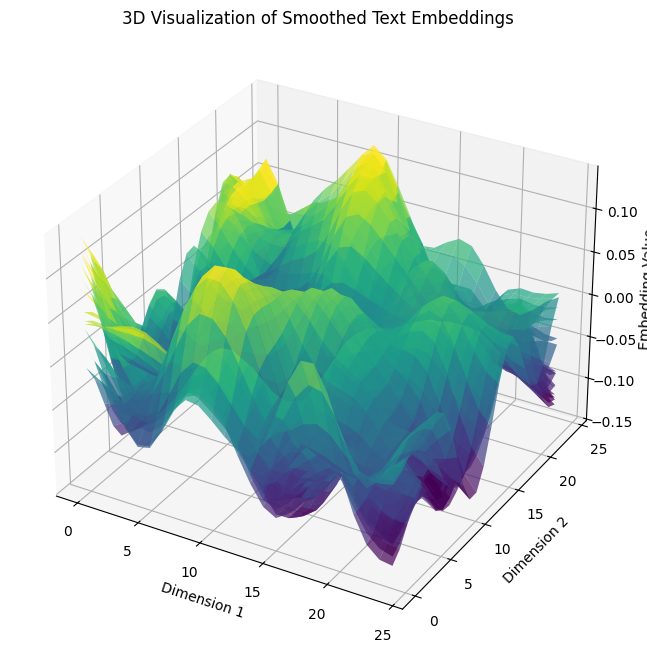

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Variance in Encoded Outputs for User Data: 0.0022446618


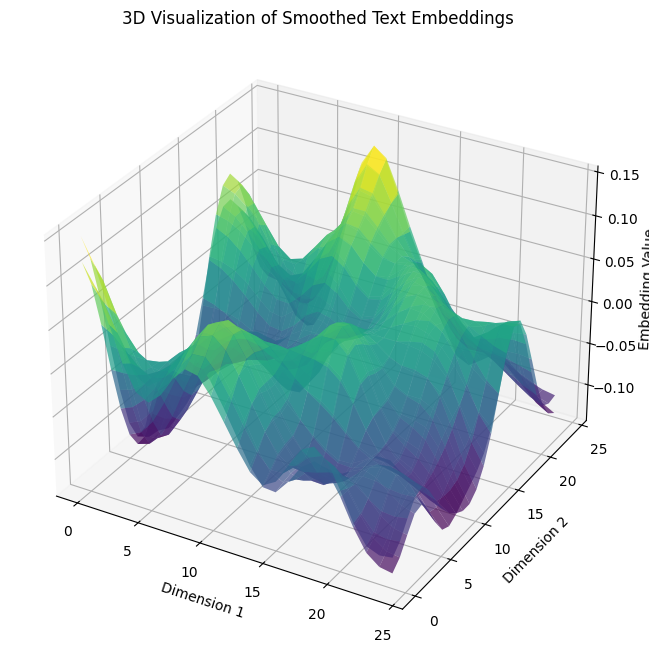

In [7]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

max_input_text_len = 500  # Set a specific maximum length for truncation
min_input_text_len = 10  # Minimum length threshold
layer_index = -1  # Use the last layer by default
scaling_factor = 1.0  # Scaling factor to amplify the embedding values

file_path = './breakingchat.txt'
user_list, chatgpt_list = parse_conversations(file_path)

print("Analyzing User Texts")
embedding_user_list = []
for text in user_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

print("Analyzing ChatGPT Texts")
embedding_chatgpt_list = []
for text in chatgpt_list:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_chatgpt_list.append(embeddings)

# Convert lists of lists to numpy arrays and reshape to remove the extra dimension
embedding_user_array = np.squeeze(np.array(embedding_user_list), axis=1)
embedding_chatgpt_array = np.squeeze(np.array(embedding_chatgpt_list), axis=1)

# Calculate variances
user_variance = np.var(embedding_user_array, axis=0).mean()
chatgpt_variance = np.var(embedding_chatgpt_array, axis=0).mean()

print(f"Mean Variance in User Embeddings: {user_variance}")
print(f"Mean Variance in ChatGPT Embeddings: {chatgpt_variance}")

# Train the autoencoder and visualize embeddings
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 50

combined_input = embedding_chatgpt_array
encoder, decoder, autoencoder = train_autoencoder(combined_input, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)

# Now predict using user data
combined_input = embedding_user_array
encoded_2d_grid = encoder.predict(combined_input).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for User Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


In [ ]:
import numpy as np

# Example prompt to be processed
prompt = "Tell me about the history of artificial intelligence."

# Number of responses you want to generate
n_responses = 2

# Call the function to get multiple responses
responses = []
for i in range(n_responses):
    response = get_full_response(prompt, n=1)
    responses.append(response)

# Initialize lists to hold response texts and top logprob words for embedding
response_texts = []
top_logprob_words_combined = []

# Process each response, print the details, and prepare for embedding
for index, response in enumerate(responses):
    print(f"Response {index + 1}:")
    data = extract_chat_completion_data(response)
    
    # Print the response content
    print("Text Response:", data["Response Content"])
    print("Logprobabilities:", data["Logprobs"])
    print("Top Logprob Words:", data["Top Logprob Words"])
    print("Top Logprob Values:", data["Top Logprob Values"])
    print("--------------------------------------------------")

    # Add response text to the list for embedding
    response_texts.append(data["Response Content"])

    # Combine all top logprob words into a single spaced string
    top_words_flat = " ".join(sum(data["Top Logprob Words"], []))
    top_logprob_words_combined.append(top_words_flat)

# Parameters for embedding
max_input_text_len = 512  # Example maximum length for embedding input
layer_index = -1  # Example layer index for obtaining embeddings
scaling_factor = 1.0  # Example scaling factor for embeddings

# Embed response texts
embedding_user_list = []
for text in response_texts:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

# Embed combined top logprob words
embedding_top_logprob_list = []
for text in top_logprob_words_combined:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_top_logprob_list.append(embeddings)

# Combine the embedding lists for autoencoder input
combined_input = embedding_user_list + embedding_top_logprob_list

# Convert the combined list to a NumPy array
combined_input_array = np.array(combined_input)

# Print the shape of the array
print("Shape of the array:", combined_input_array.shape)

# Autoencoder training parameters
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 50

# Train the autoencoder and visualize embeddings
encoder, decoder, autoencoder = train_autoencoder(combined_input_array, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


In [38]:
combined_input = embedding_user_list + embedding_top_logprob_list
# Convert the nested list to a NumPy array
array = np.array(combined_input)

# Print the shape of the array
print("Shape of the array:", array.shape)

Shape of the array: (4, 1, 4096)


In [ ]:
import numpy as np
import tensorflow as tf

# Example prompt to be processed
prompt = "Tell me about the history of artificial intelligence."

# Number of responses you want to generate
n_responses = 5

# Call the function to get multiple responses
responses = []
for i in range(n_responses):
    response = get_full_response(prompt, n=1)
    responses.append(response)

# Initialize lists to hold response texts and top logprob words for embedding
response_texts = []
top_logprob_words_combined = []

# Process each response, print the details, and prepare for embedding
for index, response in enumerate(responses):
    print(f"Response {index + 1}:")
    data = extract_chat_completion_data(response)
    
    # Print the response content
    print("Text Response:", data["Response Content"])
    print("Logprobabilities:", data["Logprobs"])
    print("Top Logprob Words:", data["Top Logprob Words"])
    print("Top Logprob Values:", data["Top Logprob Values"])
    print("--------------------------------------------------")

    # Add response text to the list for embedding
    response_texts.append(data["Response Content"])

    # Combine all top logprob words into a single spaced string
    top_words_flat = " ".join(sum(data["Top Logprob Words"], []))
    top_logprob_words_combined.append(top_words_flat)

# Parameters for embedding
max_input_text_len = 512  # Example maximum length for embedding input
layer_index = -1  # Example layer index for obtaining embeddings
scaling_factor = 1.0  # Example scaling factor for embeddings

# Embed response texts
embedding_user_list = []
for text in response_texts:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

# Embed combined top logprob words
embedding_top_logprob_list = []
for text in top_logprob_words_combined:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_top_logprob_list.append(embeddings)

# Combine the embedding lists for autoencoder input
combined_input = embedding_user_list + embedding_top_logprob_list

# Convert the combined list to a NumPy array
combined_input_array = np.array(combined_input)

# Print the shape of the array
print("Shape of the array:", combined_input_array.shape)

# Autoencoder training parameters
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 50

# Define the train_autoencoder function
def train_autoencoder(input_data, latent_dim=2500, num_epochs=50):
    # Update the input layer shape to match the input data
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    
    # Encoder configuration
    encoded = tf.keras.layers.Dense(4096, activation='relu')(encoder_input)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded = tf.keras.layers.Dense(2048, activation='relu')(encoded)
    encoded = tf.keras.layers.Dropout(0.3)(encoded)
    encoded = tf.keras.layers.Dense(1024, activation='relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    # Decoder configuration
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(1024, activation='relu')(decoder_input)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded = tf.keras.layers.Dense(2048, activation='relu')(decoded)
    decoded = tf.keras.layers.Dropout(0.3)(decoded)
    decoded = tf.keras.layers.Dense(4096, activation='relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    # Autoencoder configuration
    autoencoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded_repr = encoder(autoencoder_input)
    reconstructed_output = decoder(encoded_repr)

    autoencoder = tf.keras.Model(autoencoder_input, reconstructed_output, name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='mse')

    # Training the autoencoder
    autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=8, shuffle=True)

    return encoder, decoder, autoencoder

# Train the autoencoder and visualize embeddings
encoder, decoder, autoencoder = train_autoencoder(combined_input_array, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


In [40]:
import numpy as np
import tensorflow as tf
"""
# Example prompt to be processed
prompt = "Tell me about the history of artificial intelligence."

# Number of responses you want to generate
n_responses = 5

# Call the function to get multiple responses
responses = []
for i in range(n_responses):
    response = get_full_response(prompt, n=1)
    responses.append(response)

# Initialize lists to hold response texts and top logprob words for embedding
response_texts = []
top_logprob_words_combined = []

# Process each response, print the details, and prepare for embedding
for index, response in enumerate(responses):
    print(f"Response {index + 1}:")
    data = extract_chat_completion_data(response)
    
    # Print the response content
    print("Text Response:", data["Response Content"])
    print("Logprobabilities:", data["Logprobs"])
    print("Top Logprob Words:", data["Top Logprob Words"])
    print("Top Logprob Values:", data["Top Logprob Values"])
    print("--------------------------------------------------")

    # Add response text to the list for embedding
    response_texts.append(data["Response Content"])

    # Combine all top logprob words into a single spaced string
    top_words_flat = " ".join(sum(data["Top Logprob Words"], []))
    top_logprob_words_combined.append(top_words_flat)

# Parameters for embedding
max_input_text_len = 512  # Example maximum length for embedding input
layer_index = -1  # Example layer index for obtaining embeddings
scaling_factor = 1.0  # Example scaling factor for embeddings
"""
# Embed response texts
embedding_user_list = []
for text in response_texts:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_user_list.append(embeddings)

# Embed combined top logprob words
embedding_top_logprob_list = []
for text in top_logprob_words_combined:
    embeddings = embed_text(text, max_length=max_input_text_len, layer_index=layer_index, scaling_factor=scaling_factor)
    if embeddings is not None:
        embedding_top_logprob_list.append(embeddings)

# Combine the embeddings for each response and its corresponding top logprob words
combined_input_list = []
for user_embed, top_logprob_embed in zip(embedding_user_list, embedding_top_logprob_list):
    combined_embed = np.concatenate((user_embed, top_logprob_embed))
    combined_input_list.append(combined_embed)

# Convert the combined list to a NumPy array
combined_input_array = np.array(combined_input_list)

# Print the shape of the array
print("Shape of the array:", combined_input_array.shape)

# Autoencoder training parameters
grid_size = 25
latent_dim = grid_size * grid_size
num_epochs = 50

# Define the train_autoencoder function
def train_autoencoder(input_data, latent_dim=2500, num_epochs=50):
    # Update the input layer shape to match the input data
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    
    # Encoder configuration
    encoded = tf.keras.layers.Dense(4096, activation='relu')(encoder_input)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded = tf.keras.layers.Dense(2048, activation='relu')(encoded)
    encoded = tf.keras.layers.Dropout(0.3)(encoded)
    encoded = tf.keras.layers.Dense(1024, activation='relu')(encoded)
    encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.LeakyReLU()(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    # Decoder configuration
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(1024, activation='relu')(decoder_input)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded = tf.keras.layers.Dense(2048, activation='relu')(decoded)
    decoded = tf.keras.layers.Dropout(0.3)(decoded)
    decoded = tf.keras.layers.Dense(4096, activation='relu')(decoded)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    # Autoencoder configuration
    autoencoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded_repr = encoder(autoencoder_input)
    reconstructed_output = decoder(encoded_repr)

    autoencoder = tf.keras.Model(autoencoder_input, reconstructed_output, name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='mse')

    # Training the autoencoder
    autoencoder.fit(input_data, input_data, epochs=num_epochs, batch_size=8, shuffle=True)

    return encoder, decoder, autoencoder

# Train the autoencoder and visualize embeddings
encoder, decoder, autoencoder = train_autoencoder(combined_input_array, latent_dim, num_epochs)

# Predict using the trained encoder
encoded_2d_grid = encoder.predict(combined_input_array).reshape(-1, grid_size, grid_size)
print("Variance in Encoded Outputs for ChatGPT Data:", np.var(encoded_2d_grid, axis=0).mean())
visualize_2d_grid(encoded_2d_grid, grid_size)


Shape of the array: (5, 2, 4096)
Epoch 1/50


ValueError: Input 0 of layer "autoencoder" is incompatible with the layer: expected shape=(None, 4096), found shape=(None, 2, 4096)